In [0]:
!if [ ! -f plwordnet-4.0.xml ]; then gdown  'https://drive.google.com/uc?export=download&id=1wyjyUwoy3nqcN3ZC-SUKwoXGqPFjypVO'; fi

In [0]:
def char2vec(word, dictionary):
    word_array = []
    for character in word:
        word_array.append(dictionary[character])
    return word_array


In [0]:
import re
from IPython.display import clear_output, display
f = open('plwordnet-4.0.xml',"r")
file = f.read()
deminutives = re.findall(r"<lexicalrelations parent=\"([0-9]+)\" child=\"([0-9]+)\" relation=\"56\"\n?.*valid=\"true\" owner=\".*\"\/>", file, re.MULTILINE)

words = re.findall(r"<lexical-unit id=\"([0-9]+)\"\n?( {8})? ?name=\"(.*)\"\n?( {8})? ?pos=\"rzeczownik.*\"\n?( {8})? ?tagcount=\"[0-9]+\"\n?( {8})? ?domain=\".*\"\n?( {8})? ?desc=\".*\"\n?( {8})? ?workstate=\".*\"\n?( {8})? ?source=\".*\"\n?( {8})? ?variant=\"[0-9]+\"/>", file, re.MULTILINE)
numerated_words = {}
id_words = {}
words_dict = {}
characters = set()
relations = set()
max_len = 0
longest = ""
for deminutive in deminutives:
    relations.add(int(deminutive[0]))
    relations.add(int(deminutive[1]))

for word in words:
    for character in word[2]:
        characters.add(character)
    words_dict[int(word[0])] = word[2]


i = 0
for key, word in sorted(words_dict.items(), key = lambda kv:(kv[1], kv[0])):
    if key in relations:
        numerated_words[i] = [word, key]
        id_words[key] = [word, i]
        i+=1
        if max_len < len(word):
            max_len = len(word)

print("longest",max_len)
# print(len(sorted(characters)))
characters = [chr(0)]+ sorted(characters)
characters_dict = dict([(value, idx) for idx, value in enumerate(characters)])
print (characters_dict)
# word_to_ix = dict([(value[0], key) for key, value in numerated_words.items()])
word_to_ix = dict([(key, char2vec(value[0].ljust(max_len,chr(0)),characters_dict)) for key, value in numerated_words.items()])
print (word_to_ix)

new_relations = [(id_words[int(word2)][1], id_words[int(word1)][1]) for (word1, word2) in deminutives]
x_set = []
y_set = []
for x, y in new_relations:
    x_set.append(word_to_ix[x])
    y_set.append(word_to_ix[y])
print(len(x_set))
print(len(y_set))


longest 22
{'\x00': 0, ' ': 1, '$': 2, '&': 3, "'": 4, '(': 5, ')': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, '[': 50, ']': 51, '_': 52, '`': 53, 'a': 54, 'b': 55, 'c': 56, 'd': 57, 'e': 58, 'f': 59, 'g': 60, 'h': 61, 'i': 62, 'j': 63, 'k': 64, 'l': 65, 'm': 66, 'n': 67, 'o': 68, 'p': 69, 'q': 70, 'r': 71, 's': 72, 't': 73, 'u': 74, 'v': 75, 'w': 76, 'x': 77, 'y': 78, 'z': 79, '£': 80, '¥': 81, '°': 82, '²': 83, '³': 84, 'µ': 85, 'Å': 86, 'Æ': 87, 'É': 88, 'Ú': 89, 'Ü': 90, 'à': 91, 'á': 92, 'â': 93, 'ã': 94, 'ä': 95, 'æ': 96, 'ç': 97, 'è': 98, 'é': 99, 'ê': 100, 'ë': 101, 'í': 102, 'ð': 103, 'ñ': 104, 'ó': 105, 'ô': 106, 'ö': 107, 'ø': 108, 'ú': 

In [0]:
import torch
import numpy as np

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

N, D_in, H, D_out = len(x_set), max_len, 100000, max_len

x_numpy = np.array( x_set )
x = torch.from_numpy(x_numpy).float()
# x = x.to(device)
print(x)

cuda:0
tensor([[ 69.,  68.,  56.,  ...,   0.,   0.,   0.],
        [ 57.,  71.,  54.,  ...,   0.,   0.,   0.],
        [ 64.,  68., 129.,  ...,   0.,   0.,   0.],
        ...,
        [ 56.,  58.,  65.,  ...,   0.,   0.,   0.],
        [ 72.,  58.,  69.,  ...,   0.,   0.,   0.],
        [ 69.,  62.,  54.,  ...,   0.,   0.,   0.]])


In [0]:
y_numpy = np.array( y_set )
y = torch.from_numpy(y_numpy).float()
# y = y.to(device)

In [0]:
from torch import nn
from torch.functional import F

class NeuralNetworkModel(nn.Module):
    '''
    This Neural Network will use ReLU as the non-linear activation function, and 
    use log-softmax activation for the output and negative log likelihood function 
    for our loss function.
    '''
    def __init__(self):
        # Call the super initializor to register all of the layers implemented here
        super().__init__()

        # Create layers here
        self.layer_input = nn.Linear(D_in,H)

        self.layer_hidden_one = nn.Linear(H,1000)
        self.layer_hidden_two = nn.Linear(1000,H)
        self.layer_hidden_three = nn.Tanh()
        self.layer_dropout = nn.Dropout(p=0.5)

        self.layer_output = nn.Linear(H,D_out)
    def forward(self, param):
        # Flattened the input to make sure it fits the layer input
        # param = param.view(param.shape[0],-1)
        # Pass in the input to the layer and do forward propagation
        param = self.layer_input(param)
        # print("1")

        param =self.layer_hidden_three(param)
        param = self.layer_hidden_one(param)

        # print("2")
        param = self.layer_dropout(param)
        # print("3")
        param =self.layer_hidden_two(param)

        # print("4")
        # Dimension = 1, to get the sum of the output across the output row matrix
        param = self.layer_output(param)
        return param

In [0]:
# Instantiate the model
model = NeuralNetworkModel()
# Get the log probability prediction from our model


log_ps = model(x)
# Normalize the probability by taking the exponent of the log-prob
ps = torch.exp(log_ps)
# Print out the size
print(ps.shape)

torch.Size([4179, 22])


In [0]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model
model = NeuralNetworkModel()
# Use Negative Log Likelyhood as our loss function
loss_function = nn.MSELoss(reduction='sum')
# Use ADAM optimizer to utilize momentum and start with a very small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train the model 30 cycles
epochs = 100
# Initialize two empty arrays to hold the train and test loss every cycle
train_losses, test_losses = [],[]

model.to(device)
x_train = x[0:3000]
y_train = y[0:3000]


x_test = x[3001:]
y_test = y[3001:]
trainloader = [xval for xval in x_train]
# print (trainloader)
for i in range(len(trainloader)):
    trainloader[i] = [trainloader[i], y_train[i]]
testloader = [xval for xval in x_test]
for i in range(len(testloader)):
    testloader[i] = [testloader[i], y_test[i]]


print(len(x_train[0]))
# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    # for x,y in trainloader:
    x_train,y_train = x_train.to(device), y_train.to(device)

    optimizer.zero_grad()                      # Clear the previous gradients
    log_ps = model(x_train)                     # Forwardpropagate 
    loss = loss_function(log_ps, y_train)       # Calculate the loss
    loss.backward()                            # Backpropagate
    optimizer.step()                           # Update the weights
    running_loss += loss.item()                # Accumulate the total loss

    # Initialize test loss and accuracy to be 0 for every start of cycle    
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Loop through all of the validation set and calculate the validation loss
        # for x, y in testloader:
        x_test,y_test = x_test.to(device), y_test.to(device)
        log_ps = model(x_test)                                 # Forwardpropagate
        ps = torch.exp(log_ps)                                 # Normalize the log-prob
        test_loss += loss_function(log_ps, y_test)             # Accumulate test loss
        top_p, top_class = ps.topk(max_len,1)                    # Get the top probability
        # print(len(top_p), top_class.shape)
        # print(y_test.shape, top_class.shape)
        equals = top_class == y_test.view(*top_class.shape)    # Compare equality with label
        accuracy += torch.mean(equals.type(torch.FloatTensor)) # Get mean of accuracy
    
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    # Print the result
    if (i+1)%100 == 0:
        clear_output(wait=True)
        print("Epoch: {}/{}.. ".format(i+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 100/100..  Training Loss: 4686642.517..  Test Loss: 4909582.000..  Test Accuracy: 0.000


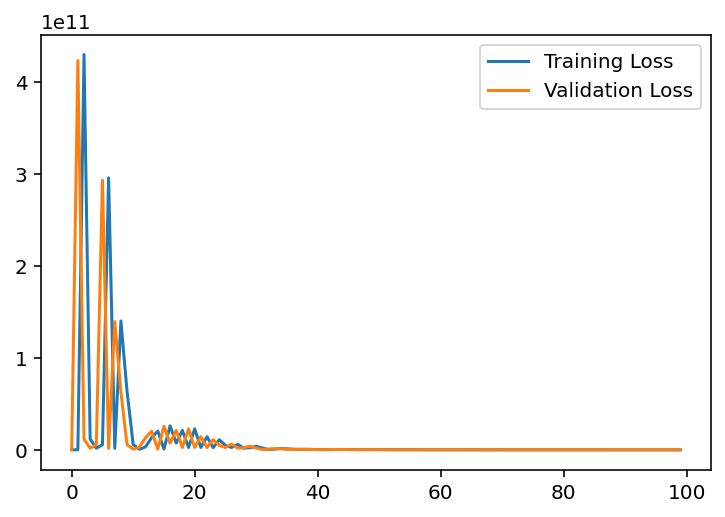

In [0]:
# Plot the graph here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)